# PaddleOCR with OpenVINO

This demo shows how to run PPOCR model on OpenVINO natively. Instead of exporting the PaddlePaddle model to ONNX and then convert to the Intermediate Representation (IR) format through OpenVINO Model Optimizer, we can now read directly from the PaddlePaddle Model without any conversions. [PaddleOCR](https://github.com/PaddlePaddle/PaddleOCR) is an ultra-light OCR model trained with PaddlePaddle deep learning framework, that aims to create multilingual and practical OCR tools. 

The paddleOCR pre-trained model used in the demo refer to the "Chinese and English ultra-lightweight PP-OCR model (9.4M)". More open-sourced pre-trained models could be downloaded at [PaddleOCR Github](https://github.com/PaddlePaddle/PaddleOCR)  or [PaddleOCR Gitee](https://gitee.com/paddlepaddle/PaddleOCR). Working pipeline of the paddleOCR is as follows:


## Imports

In [1]:
import sys
import os
import cv2
import numpy as np
import paddle
import math
import time
import collections
from PIL import Image
from pathlib import Path
import tarfile
import urllib.request

from openvino.runtime import Core
from IPython import display
import copy

sys.path.append("../utils")
import notebook_utils as utils
import pre_post_processing as processing

## Various ways to show an image

In [101]:
%matplotlib inline
from matplotlib import pyplot as plt

def show_imgfile( imgf:str):
    img = Image.open( imgf)    
    print('image from PIL is ', img)
    print('image from PIL shape is ', np.array(img).shape) #to opencv numpy
    img.show()   
    

def show_imgfile_plt( imgf:str):
    imgary = cv2.imread(imgf)
    print('numpy image shape is ', imgary.shape)
    plt.imshow(cv2.cvtColor( imgary, cv2.COLOR_RGB2BGR))
    plt.show()

def show_npimg( imgary: np.ndarray):
    imgary = cv2.cvtColor( imgary, cv2.COLOR_BGR2RGB)
    img = Image.fromarray( imgary)
    img.show()


below image is  t0.jpg
image from PIL is  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1998x1080 at 0x7FF274555520>
image from PIL shape is  (1080, 1998, 3)


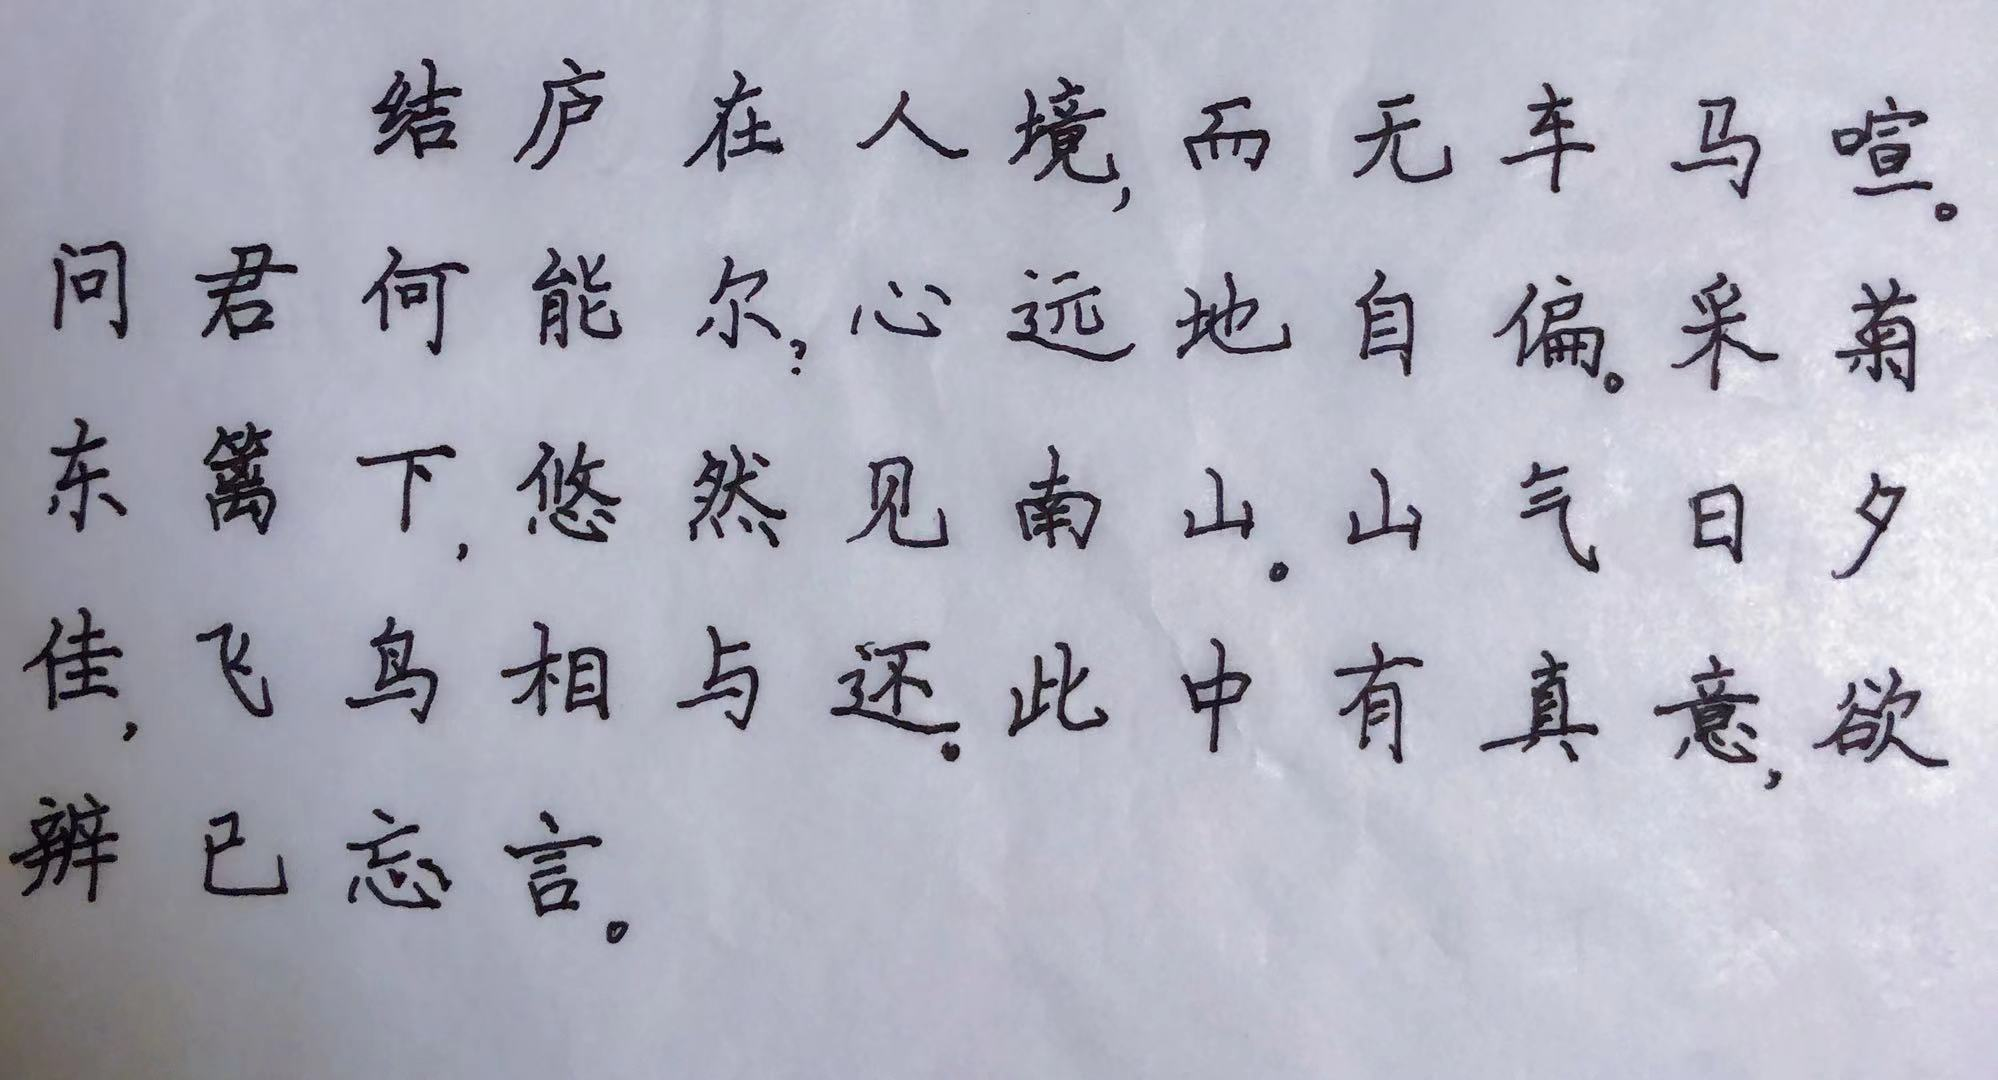

below image is  t1.jpg
image from PIL is  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=346x500 at 0x7FF27B978AF0>
image from PIL shape is  (500, 346, 3)


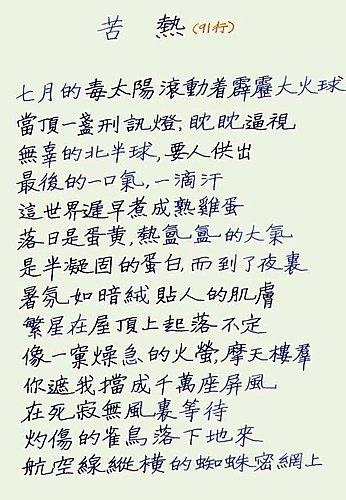

below image is  t2.jpg
image from PIL is  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2048x1449 at 0x7FF27B978AF0>
image from PIL shape is  (1449, 2048, 3)


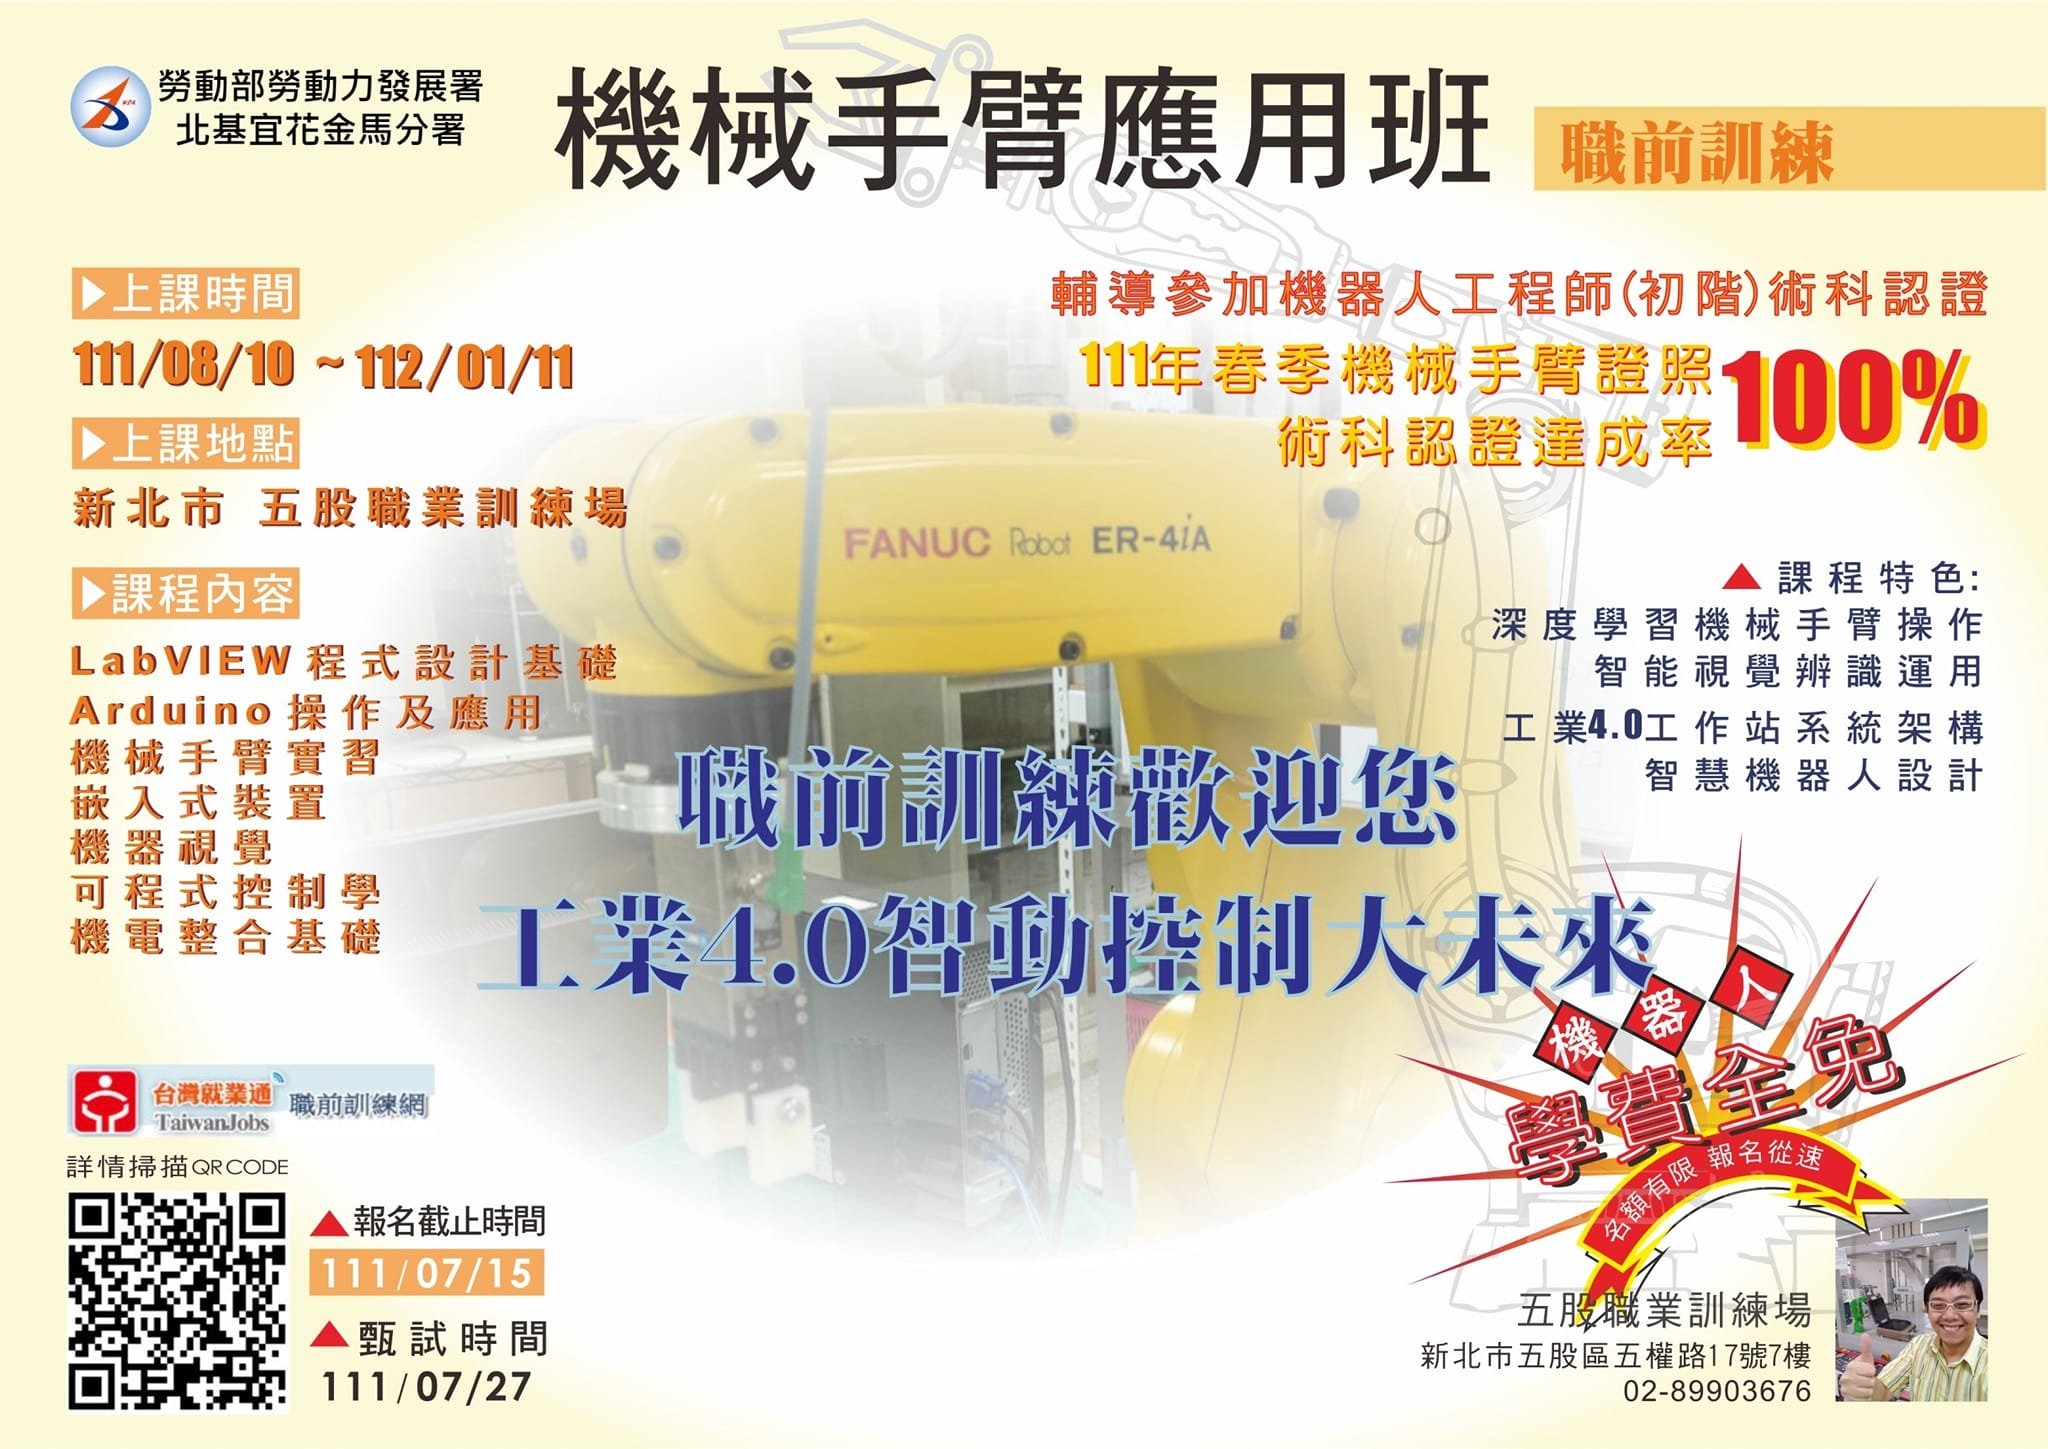

below image is  t3.jpg
image from PIL is  <PIL.WebPImagePlugin.WebPImageFile image mode=RGB size=620x378 at 0x7FF2E22465B0>
image from PIL shape is  (378, 620, 3)


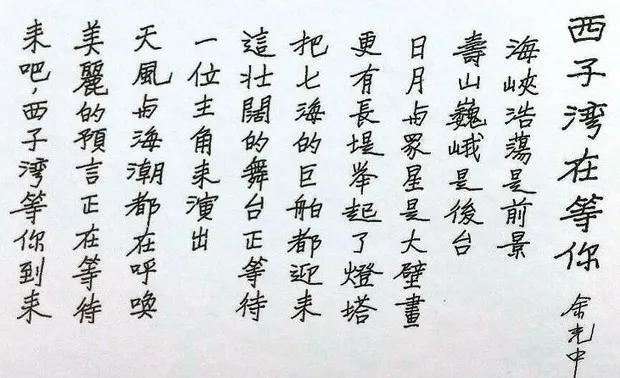

In [222]:
imgurls=[
    "https://raw.githubusercontent.com/raymondlo84/openvino-paddlepaddle-demo/main/notebooks/200-PaddleOCR/handwritten_simplified_chinese_test.jpg",
    "https://4.share.photo.xuite.net/ctchihuang520/14baca9/9029792/382785801_m.jpg",
    "https://pbs.twimg.com/media/FT-LoD-aAAAh_LO?format=jpg&name=large",
    "https://cw-image-resizer.cwg.tw/resize/uri/http%3A%2F%2Fcw1.tw%2FCW%2Fimages%2Ffck%2FF1446511421728.jpg/?w=1260&format=webp"
  
]

for idx, img_url in enumerate(imgurls):
    dstfn=f"t{idx}.jpg"
    urllib.request.urlretrieve( img_url, dstfn)
    print( 'below image is ', dstfn)
    show_imgfile( dstfn)


### Models for PaddleOCR

PaddleOCR includes two parts of deep learning models, text detection and text recognition. Pre-trained models used in the demo are downloaded and stored in the "model" folder. Other pre-trained models for PaddleOCR could be download at [PaddleOCR Github](https://github.com/PaddlePaddle/PaddleOCR)  or [PaddleOCR Gitee](https://gitee.com/paddlepaddle/PaddleOCR).

Only a few lines of code are required to run the model. First, we initialize the runtime for inference. Then we read the network architecture and model weights from the `.pdmodel` and `.pdiparams` files to load onto the CPU.

In [2]:
# Define the function to download text detection and recognition models from PaddleOCR resources

def run_model_download(model_url, model_file_path):
    """
    Download pre-trained models from PaddleOCR resources

    Parameters:
        model_url: url link to pre-trained models
        model_file_path: file path to store the downloaded model
    """
    model_name = model_url.split("/")[-1]
    
    if model_file_path.is_file(): 
        print("Model already exists")
    else:
        # Download the model from the server, and untar it.
        print("Downloading the pre-trained model... May take a while...")

        # create a directory
        os.makedirs("model", exist_ok=True)
        urllib.request.urlretrieve(model_url, f"model/{model_name} ")
        print("Model Downloaded")

        file = tarfile.open(f"model/{model_name} ")
        res = file.extractall("model")
        file.close()
        if not res:
            print(f"Model Extracted to {model_file_path}.")
        else:
            print("Error Extracting the model. Please check the network.")

#### Download the Model for Text **Detection**

In [3]:
# Directory where model will be downloaded
# for more models, please check https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/doc/doc_ch/models_list.md
det_model_url = "https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_det_infer.tar"
det_model_file_path = Path("model/ch_ppocr_mobile_v2.0_det_infer/inference.pdmodel")

run_model_download(det_model_url, det_model_file_path)

Model Downloaded
Model Extracted to model/ch_ppocr_mobile_v2.0_det_infer/inference.pdmodel.


#### Load the Model for Text **Detection**

In [4]:
# initialize inference engine for text detection
core = Core()
det_model = core.read_model(model=det_model_file_path)
det_compiled_model = core.compile_model(model=det_model, device_name="CPU")

# get input and output nodes for text detection
det_input_layer = det_compiled_model.input(0)
det_output_layer = det_compiled_model.output(0)

#### Download the Model for Text **Recognition**

In [5]:
# for more models, please check https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/doc/doc_ch/models_list.md
rec_model_url = "https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_rec_infer.tar"
rec_model_file_path = Path("model/ch_ppocr_mobile_v2.0_rec_infer/inference.pdmodel")

run_model_download(rec_model_url, rec_model_file_path)

Model Downloaded
Model Extracted to model/ch_ppocr_mobile_v2.0_rec_infer/inference.pdmodel.


#### Load the Model for Text **Recognition** with Dynamic Shape

Input to text recognition model refers to detected bounding boxes with different image sizes, i.e, dynamic input shapes. Hence:

1. Input dimension with dynamic input shapes needs to be specified before loading text recognition model
2. Dynamic shape is specified by assigning -1 to the input dimension or by setting the upper bound of the input dimension using, for example, Dimension(1, 512)

In [6]:
# read the model and corresponding weights from file
rec_model = core.read_model(model=rec_model_file_path)

# assign dynamic shapes to every input layer on the last dimension
for input_layer in rec_model.inputs:
    input_shape = input_layer.partial_shape
    input_shape[3] = -1
    rec_model.reshape({input_layer: input_shape})

rec_compiled_model = core.compile_model(model=rec_model, device_name="CPU")

# get input and output nodes
rec_input_layer = rec_compiled_model.input(0)
rec_output_layer = rec_compiled_model.output(0)

### Preprocessing image functions for text detection and recognition

Define preprosessing functions for text detection and recognition:
1. Preprocessing for text detection: resize and normalize input images
2. Preprocessing for text recognition: resize and normalize detected box images to the same size (e.g. size (3, 32, 320) for images with Chinese text) for easy batching in inference

In [7]:
# Preprocess for text detection
def image_preprocess(input_image, size):
    """
    Preprocess input image for text detection

    Parameters:
        input_image: input image 
        size: value for the image to be resized for text detection model
    """
    img = cv2.resize(input_image, (size, size))
    img = np.transpose(img, [2, 0, 1]) / 255
    img = np.expand_dims(img, 0)
    # NormalizeImage: {mean: [0.485, 0.456, 0.406], std: [0.229, 0.224, 0.225], is_scale: True}
    img_mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    img_std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))
    img -= img_mean
    img /= img_std
    return img.astype(np.float32)

In [8]:
# Preprocess for text recognition
def resize_norm_img(img, max_wh_ratio):
    """
    Resize input image for text recognition

    Parameters:
        img: bounding box image from text detection 
        max_wh_ratio: value for the resizing for text recognition model
    """
    rec_image_shape = [3, 32, 320]
    imgC, imgH, imgW = rec_image_shape
    assert imgC == img.shape[2]
    character_type = "ch"
    if character_type == "ch":
        imgW = int((32 * max_wh_ratio))
    h, w = img.shape[:2]
    ratio = w / float(h)
    if math.ceil(imgH * ratio) > imgW:
        resized_w = imgW
    else:
        resized_w = int(math.ceil(imgH * ratio))
    resized_image = cv2.resize(img, (resized_w, imgH))
    resized_image = resized_image.astype('float32')
    resized_image = resized_image.transpose((2, 0, 1)) / 255
    resized_image -= 0.5
    resized_image /= 0.5
    padding_im = np.zeros((imgC, imgH, imgW), dtype=np.float32)
    padding_im[:, :, 0:resized_w] = resized_image
    return padding_im


def batch_text_box(dt_boxes, frame):
    """
    Batch the detected bounding boxes for text recognition

    Parameters:
        dt_boxes: detected bounding boxes from text detection 
        frame: original input frame 
    """
    
    ori_im = frame.copy()
    img_crop_list = [] 
    for bno in range(len(dt_boxes)):
        tmp_box = copy.deepcopy(dt_boxes[bno])
        img_crop = processing.get_rotate_crop_image(ori_im, tmp_box)
        img_crop_list.append(img_crop)
        
    img_num = len(img_crop_list)
    # Calculate the aspect ratio of all text bars
    width_list = []
    for img in img_crop_list:
        width_list.append(img.shape[1] / float(img.shape[0]))
    # Sorting can speed up the recognition process
    indices = np.argsort(np.array(width_list))
    rec_res = [['', 0.0]] * img_num
    batch_num = 6

    # For each detected text box batch, run inference for text recognition
    for beg_img_no in range(0, img_num, batch_num):
        end_img_no = min(img_num, beg_img_no + batch_num)

        norm_img_batch = []
        max_wh_ratio = 0
        for ino in range(beg_img_no, end_img_no):
            h, w = img_crop_list[indices[ino]].shape[0:2]
            wh_ratio = w * 1.0 / h
            max_wh_ratio = max(max_wh_ratio, wh_ratio)
        for ino in range(beg_img_no, end_img_no):
            norm_img = resize_norm_img(img_crop_list[indices[ino]], max_wh_ratio)
            norm_img = norm_img[np.newaxis, :]
            norm_img_batch.append(norm_img)

    norm_img_batch = np.concatenate(norm_img_batch)
    norm_img_batch = norm_img_batch.copy()
    return norm_img_batch, rec_res, indices, beg_img_no

### Postprocessing image for text detection

In [9]:
def post_processing_detection(frame, det_results):
    """
    Postprocess the results from text detection into bounding boxes

    Parameters:
        frame: input image 
        det_results: inference results from text detection model
    """   
    ori_im = frame.copy()
    data = {'image': frame}
    data_resize = processing.DetResizeForTest(data)
    data_list = []
    keep_keys = ['image', 'shape']
    for key in keep_keys:
        data_list.append(data_resize[key])
    img, shape_list = data_list

    shape_list = np.expand_dims(shape_list, axis=0) 
    pred = det_results[0]    
    if isinstance(pred, paddle.Tensor):
        pred = pred.numpy()
    segmentation = pred > 0.3

    boxes_batch = []
    for batch_index in range(pred.shape[0]):
        src_h, src_w, ratio_h, ratio_w = shape_list[batch_index]
        mask = segmentation[batch_index]
        boxes, scores = processing.boxes_from_bitmap(pred[batch_index], mask, src_w, src_h)
        boxes_batch.append({'points': boxes})
    post_result = boxes_batch
    dt_boxes = post_result[0]['points']
    dt_boxes = processing.filter_tag_det_res(dt_boxes, ori_im.shape)    
    return dt_boxes

### Main processing function for PaddleOCR

See the list of procedures below:

1. Download images
2. Prepare a set of images for text detection and recognition.
3. Run AI inference for both text detection and recognition.
4. Visualize the results.

In [224]:
class PPOCR:
    def __init__( self, fn:str):
        img = cv2.imread(fn)
        self.oimg = img
        self.img = image_preprocess( img, 640)
        self.dt_boxes = []
        self.shown = False

    def showimage( self, shown: bool):
        self.shown = shown
    
    def doocr( self):
        self.text_detect()
        self.text_recognize()
        
    def text_detect( self):
        # perform the inference step
        det_results = det_compiled_model([self.img])[det_output_layer]
        # Postprocessing for Paddle Detection
        dt_boxes = post_processing_detection( self.oimg, det_results)        
        if self.shown:
            img1 = self.oimg.copy()
            processing.draw_text_det_res(  dt_boxes, img1)
            show_npimg( img1)        
        self.dt_boxes = processing.sorted_boxes(dt_boxes)

    def text_recognize( self ):
        # Recognition starts from here
        norm_img_batch, rec_res, indices, beg_img_no = batch_text_box( self.dt_boxes, self.oimg)
        # Run inference for text recognition 
        rec_results = rec_compiled_model([norm_img_batch])[rec_output_layer]

        # Postprocessing recognition results
        postprocess_op = processing.build_post_process(processing.postprocess_params)
        rec_result = postprocess_op(rec_results)
        for rno in range(len(rec_result)):
            rec_res[indices[beg_img_no + rno]] = rec_result[rno]            
        self.rec_res = rec_res        
        if rec_res==None:
            return
        if self.shown:
            img = Image.fromarray( self.oimg)            
            txts = [rec_res[i][0] for i in range(len(rec_res))] 
            scores = [rec_res[i][1] for i in range(len(rec_res))] 
            # draw text recognition results beside the image            
            draw_img = processing.draw_ocr_box_txt(img, self.dt_boxes, txts, scores, drop_score=0.5)
            show_npimg( draw_img)
    def dump_results(self):
        for i, res in enumerate(self.rec_res):
            [txt,score] = res
            if score <0.1:
                continue
            box = self.dt_boxes[i]
            print(f'{txt} at {box[0]} with score {score}')
            


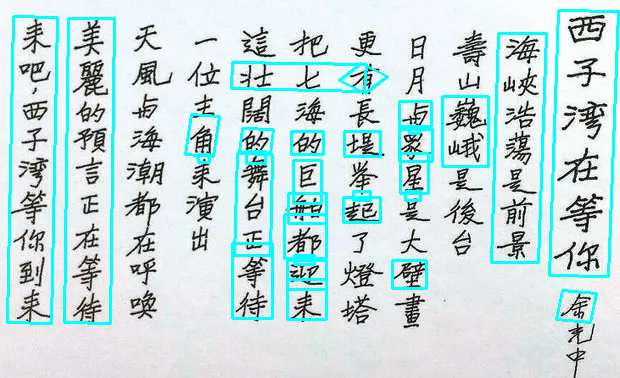

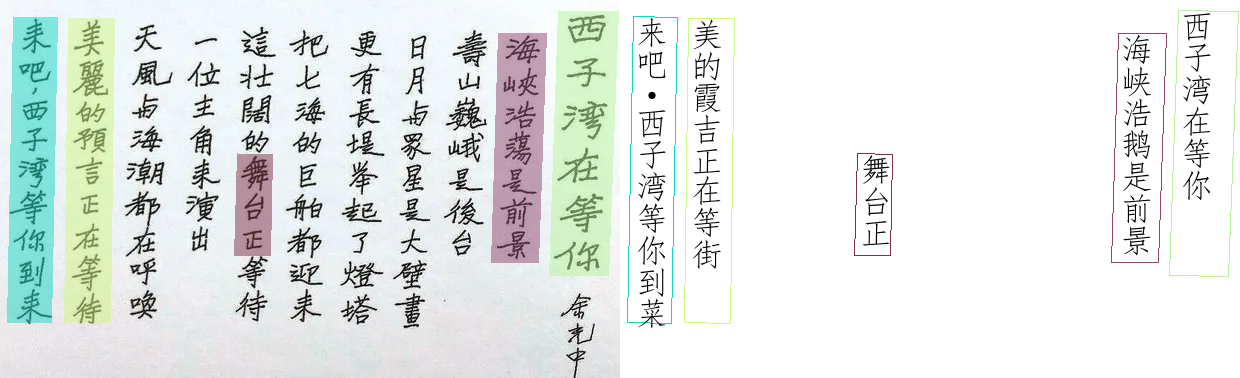

来吧·西子湾等你到菜 at [13. 16.] with score 0.6729273796081543
美的霞吉正在等街 at [68. 18.] with score 0.6547333002090454
西子湾在等你 at [558.  10.] with score 0.803947389125824
海峡浩鹅是前景 at [498.  33.] with score 0.62738436460495
壮上 at [232.  62.] with score 0.26771366596221924
舞台正 at [237. 153.] with score 0.9380478858947754


In [225]:
fn='t3.jpg'
pocr=PPOCR(fn)
pocr.showimage(True)
pocr.doocr()
pocr.dump_results()


